(256, 256, 3)


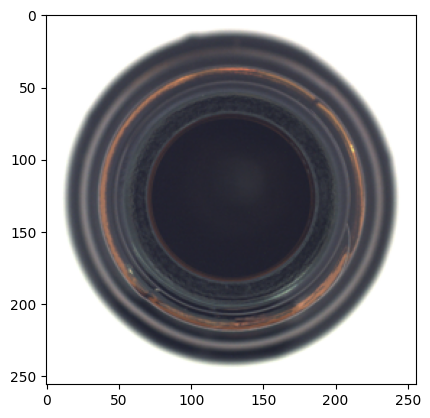

In [19]:
from sklearn.feature_extraction import image
from sklearn.feature_extraction.image import reconstruct_from_patches_2d
from PIL import Image, ImageOps
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
from torchvision.transforms import ToTensor


x = Image.open('../dataset/bottle/train/good/000.png').resize((256,256)).convert('RGB')
print(np.array(x).shape)
plt.imshow(x)

In [12]:
# input image shape must be (1, 3, imsize, imsize)
# output will be (n_patches, 3, dim_patch, dim_patch)
from torch import Tensor

def extract_patches(image:Tensor, dim=64, stride=32):
    patches = image.unfold(2, dim, stride).unfold(3, dim, stride)
    patches = patches.reshape(1, 3, -1, dim, dim)
    patches = patches.squeeze()
    patches = torch.permute(patches, (1,0,2,3))
    return patches

img = ToTensor()(x)
img = img.unsqueeze(0)
print(img.shape)
p = extract_patches(img, 64, 64)
#p = torch.permute(p, (0, 2,3,1))
print(p.shape)

torch.Size([1, 3, 256, 256])
torch.Size([16, 3, 64, 64])


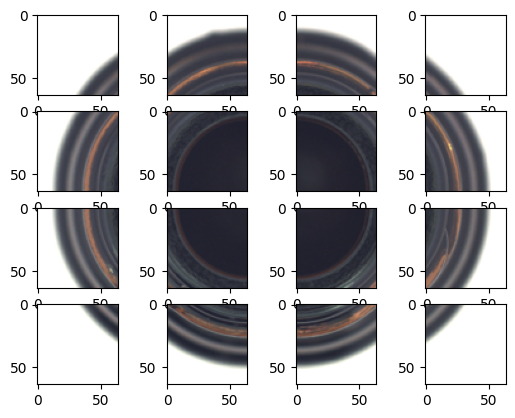

In [15]:
pp = torch.permute(p, (0, 2,3,1))
fig, ax = plt.subplots(4,4)
k = 0
for i in range(4):
    for j in range(4):
        ax[i][j].imshow(np.array(pp[k]))
        k += 1

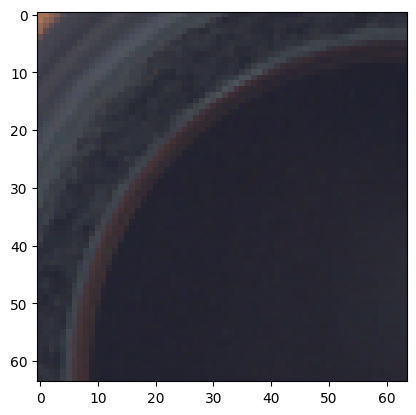

In [75]:
plt.imshow(pp[5])

In [74]:
patch = transforms.ToPILImage('RGB')(p[5])
imarray = np.array(patch)
color = imarray.mean(axis=(0,1))
rgb1 = (float(color[0]/255), float(color[1]/255), float(color[2]/255))
print(rgb1)

(0.17453086703431372, 0.17367972579656862, 0.21652784160539215)


In [20]:
def generate_patch(
        image, 
        area_ratio:tuple=(0.02, 0.15), 
        aspect_ratio:tuple=((0.3, 1),(1, 3.3)),
        augs=None,
        colorized:bool=False,
        color_type:str='random'):

    img_area = image.size[0] * image.size[1]
    patch_area = random.uniform(area_ratio[0], area_ratio[1]) * img_area
    patch_aspect = random.choice([random.uniform(*aspect_ratio[0]), random.uniform(*aspect_ratio[1])])
    patch_w  = int(np.sqrt(patch_area*patch_aspect))
    patch_h = int(np.sqrt(patch_area/patch_aspect))
    org_w, org_h = image.size

    # parte da tagliare
    patch_left, patch_top = random.randint(0, org_w - patch_w), random.randint(0, org_h - patch_h)
    patch_right, patch_bottom = patch_left + patch_w, patch_top + patch_h
    
    if colorized:
        if color_type=='random':
            rgb = (
                random.randint(0,255),
                random.randint(0,255),
                random.randint(0,255)
            )
        elif color_type=='sample':
            rgb = random.choice(['black','white','green','red','yellow','orange','cyan'])
        elif color_type=='average':
            patch = image.crop((patch_left, patch_top, patch_right, patch_bottom))
            imarray = np.array(patch)
            color = imarray.mean(axis=(0,1))
            rgb = (int(color[0]), int(color[1]), int(color[2]))
        cropped_patch = Image.new('RGBA', (patch_w, patch_h), color=rgb)
    else:
        cropped_patch = image.crop((patch_left, patch_top, patch_right, patch_bottom))

    if augs and colorized==False:
        cropped_patch = augs(cropped_patch)
    return cropped_patch

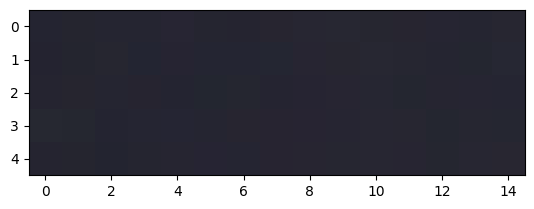

In [76]:
defect = generate_patch(
    patch,
    area_ratio=(0.02, 0.03),
    aspect_ratio=((0.3, 0.9),(1.1, 3.3))
)
plt.imshow(defect)

In [77]:
imarray = np.array(defect)
color = imarray.mean(axis=(0,1))
rgb2 = (float(color[0]/255), float(color[1]/255), float(color[2]/255))
print(rgb2)

(0.1473986928104575, 0.1459346405228758, 0.19226143790849673)


0.9996557239638768


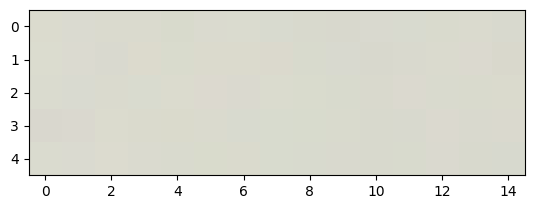

In [78]:
from sklearn.metrics.pairwise import cosine_similarity
v1 = np.array(rgb1)[None, :]
v2 = np.array(rgb2)[None, :]
out = cosine_similarity(v1, v2)
print(out.squeeze())
if out > 0.999:
    inverted = ImageOps.invert(defect)
else:
    inverted = defect
plt.imshow(inverted)

    